In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
directory = '../data/symlink_data/all_US_wild_est'

In [58]:
batch_size = 16
img_size = 350

In [59]:
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    validation_split=0.25, subset='training', interpolation='bilinear', follow_links=True
)
# this batch size is how it divides the data in the epochs below

Found 31498 files belonging to 2 classes.
Using 23624 files for training.


In [49]:
X_train

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [60]:
# while troubleshooting below issue, just use train and test for now
X_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42, 
    validation_split=0.25, subset='validation', interpolation='bilinear', follow_links=True
)

Found 31498 files belonging to 2 classes.
Using 7874 files for validation.


In [56]:
# set the batch size to the entire set so we can split it
X_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=7874, image_size=(img_size, img_size), shuffle=True, seed=42, 
    validation_split=0.25, subset='validation', interpolation='bilinear', follow_links=True
)

Found 31498 files belonging to 2 classes.
Using 7874 files for validation.


In [36]:
# calc sizes
holdout_size = int(0.3 * 7874)
test_size = 7874 - holdout_size
print(f' holdout size: {holdout_size}, test size: {test_size}')

# pull X and y in tensors
X_test_images, X_test_labels = next(iter(X_test))
# split the first into holdout
X_holdout_images = X_test_images[:holdout_size,...]
X_holdout_labels = X_test_labels[:holdout_size]
# put the rest in X_test
X_test_images = X_test_images[holdout_size:,...]
X_test_labels = X_test_labels[holdout_size:]

 holdout size: 2362, test size: 5512


In [50]:
X_train_images, X_train_labels = next(iter(X_train))

In [57]:
X_test_images, X_test_labels = next(iter(X_test))

In [51]:
X_train_images.shape

TensorShape([32, 256, 256, 3])

In [55]:
X_test_images.shape

TensorShape([32, 256, 256, 3])

In [54]:
len(X_test_images)

32

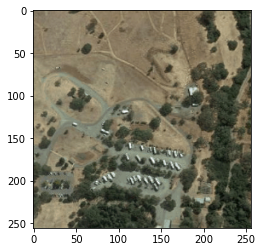

In [53]:
plt.imshow(X_test_images[0].numpy().astype('uint8'))

In [38]:
X_test_images.shape

TensorShape([5512, 256, 256, 3])

In [42]:
X_test1

<TensorDataset shapes: ((5512, 256, 256, 3), (5512,)), types: (tf.float32, tf.int32)>

In [8]:
# put into datasets
X_test1 = tensorflow.data.Dataset.from_tensors((X_test_images, X_test_labels))
X_holdout1 = tensorflow.data.Dataset.from_tensors((X_holdout_images, X_holdout_labels))

In [18]:
X_train

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
X_test1

<TensorDataset shapes: ((5512, 256, 256, 3), (5512,)), types: (tf.float32, tf.int32)>

In [19]:
new = X_test1.map(lambda image: tensorflow.image.resize_image_with_crop_or_pad(image, 256, 256))

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


In [45]:
new = X_test1.batch(1, drop_remainder=True)

In [48]:
new = X_test1.map(batch(32))

NameError: name 'batch' is not defined

In [14]:
new = tensorflow.stack(X_test1, 1)

TypeError: 'TensorDataset' object is not subscriptable

In [9]:
X_train.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
X_holdout1.element_spec

(TensorSpec(shape=(2362, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(2362,), dtype=tf.int32, name=None))

In [11]:
X_test1.element_spec

(TensorSpec(shape=(5512, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(5512,), dtype=tf.int32, name=None))

In [10]:
X_test.class_names

['Established Campground', 'Wild Camping']

In [11]:
# X_test.element_spec

In [12]:
# from tensorflow.data.experimental import save
# save(X_train, 'data/X_train', compression='GZIP', shard_func=None)
# save(X_test, 'data/X_test', compression='GZIP', shard_func=None)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import data

In [14]:
##### SAVE DATASETS ##### this takes alot of ram..

In [24]:
from tensorflow.data.experimental import save

In [61]:
save(X_train, '../data/datasets/all_US_data/X_train_350px', compression='GZIP', shard_func=None)

In [ ]:
save(X_test, '../data/datasets/all_US_data/X_test_full_350px', compression='GZIP', shard_func=None)

In [ ]:
save(X_train, '../data/datasets/all_US_data/X_train_16batch', compression='GZIP', shard_func=None)

In [ ]:
save(X_test, '../data/datasets/all_US_data/X_test_16batch', compression='GZIP', shard_func=None)

In [16]:
save(X_test1, '../data/datasets/all_US_data/X_test', compression='GZIP', shard_func=None)

In [17]:
save(X_holdout1, '../data/datasets/all_US_data/X_holdout', compression='GZIP', shard_func=None)

In [18]:
num_classes = 2
epochs = 1 # number of passes through the entire train dataset before weights "final"
AUTOTUNE = data.experimental.AUTOTUNE
img_height = 256
img_width = 256
nb_filters = 32    # number of convolutional filters to use - want 1 for each "feature" you think exists in images if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features
X_train = X_train.cache().shuffle(32).prefetch(buffer_size=AUTOTUNE) 
X_test = X_test1.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(nb_filters, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # was 16, 32, 64
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*2, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # drop layers.. for initial testing
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*3, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*4, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    # insert more layers?
    # insert callback?
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # increase this? add another dense layer?
    layers.Dropout(0.5),
    #layers.Dense(num_classes, activation='relu') # or sigmoid for binary? relu?
    layers.Dense(1, activation='sigmoid') # or sigmoid for binary? relu?
])

In [20]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
              # if multiclass then use this:
              #loss = keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics = ['accuracy'])

In [21]:
# check model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8

In [22]:
# run it
# try more epochs (maybe 1000.. at least 100)
history = model.fit(
            X_train,
            validation_data = X_test1,
            epochs = 1,
            #batch_size=batch_size,
            verbose = 1
) # weighted_metrics

 85/739 [==>...........................] - ETA: 19:17 - loss: 0.6938 - accuracy: 0.5544

KeyboardInterrupt: 

In [153]:
score = model.evaluate(X_test, verbose=1) 
print('Test score:', score[0])
print('Test accuracy:', score[1])  

1/1 [==============================] - 0s 69ms/step - loss: 0.6401 - accuracy: 0.6710
Test score: 0.6400513052940369
Test accuracy: 0.6710109114646912
